In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp_amazy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [5]:
!pip freeze > requirements.txt

# SETUP

In [6]:
CONFIG_DIR = '../app/'

In [7]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [8]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-30'

In [17]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 100],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1500],
            #'token_all_activity_3H': [0, 30],
            #'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [10]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1664882710,49829,29841,sell,0x287a3187a2b5584f8f8798ec36f45cc2336d7b74,NaN,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,395.0,453.0,100.0,553.0
1,1664882656,49828,40251,sell,0x4295e2baeb32a09c039f9473f9bd5d7074d38649,NaN,0.84,sneakers,common,sprinter,...,0.62,0.62,0.62,93.0,138.0,252.0,394.0,452.0,100.0,552.0
2,1664882641,49827,21513,sell,0xea16bf173dd03fc75961cc9b31b3ab1734528c60,NaN,0.77,sneakers,common,hiker,...,0.65,0.62,0.62,44.0,53.0,141.0,393.0,451.0,100.0,551.0
3,1664882638,49823,23016,buy,0x7a90ded76bb5ff4991b415f25db78ee72c4996e8,0x4af24870c2f593937ffd8d52ba0ae0895dd21805,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,394.0,452.0,100.0,552.0
4,1664882626,49826,35908,sell,0x550ac8e10d959caad354529c4a2f9f67d2471968,NaN,0.84,sneakers,common,sprinter,...,0.62,0.62,0.62,92.0,137.0,251.0,393.0,451.0,100.0,551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71918,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71919,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71920,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71921,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [12]:
data.columns[50:]

Index(['wallet_box_mint', 'wallet_sneaker_mint', 'time_level_up',
       'time_level_up_for_mint', 'base_mint_price_amt', 'base_mint_price_azy',
       'base_mint_price_bnb', 'predict_base', 'predict', 'diff_prev_price',
       'count_waller_buyer', 'count_holder', 'count_sneaker',
       'count_sneaker_type', 'count_new_sneaker_1d', 'count_new_sneaker_7d',
       'count_new_sneaker_14d', 'count_new_sneaker_30d',
       'ratio_sneaker_genesis', 'mkr_floor__rarity_type_genesis_lvl_mint',
       'mrk_floor__rarity_type_genesis_lvl', 'mrk_floor__rarity_type_genesis',
       'mrk_floor__rarity_type', 'mrk_floor__all',
       'mkr_count__rarity_type_genesis_lvl_mint',
       'mrk_count__rarity_type_genesis_lvl', 'mrk_count__rarity_type_genesis',
       'mrk_count__rarity_type', 'mrk_count__sneaker_all',
       'mrk_count__box_all', 'mrk_count__all'],
      dtype='object')

In [13]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71923 entries, 0 to 71922
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  43892 non-null  float64
 1   time_ownership             43892 non-null  float64
 2   wallet_box_mint            43892 non-null  float64
 3   wallet_sneaker_mint        43892 non-null  float64
 4   time_level_up              46377 non-null  float64
 5   time_level_up_for_mint     50215 non-null  float64
 6   base_mint_price_amt        50215 non-null  float64
 7   base_mint_price_azy        50215 non-null  float64
 8   base_mint_price_bnb        40192 non-null  float64
dtypes: float64(9)
memory usage: 4.9 MB


In [14]:
data.genesis

0         True
1        False
2         True
3         True
4        False
         ...  
71918     True
71919    False
71920    False
71921    False
71922     True
Name: genesis, Length: 71923, dtype: bool

In [15]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
3,1664882638,49823,23016,buy,0x7a90ded76bb5ff4991b415f25db78ee72c4996e8,0x4af24870c2f593937ffd8d52ba0ae0895dd21805,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,394.0,452.0,100.0,552.0
15,1664882238,49416,37493,buy,0xba66c77c523624341a1f8961812cb74ddd4e35bd,0x9c9ff7098114deb4b9188ca5eaf1ff9213391026,3.70,sneakers,uncommon,hiker,...,1.72,1.72,0.62,2.0,2.0,49.0,56.0,450.0,100.0,550.0
16,1664882082,49816,48699,buy,0xf33443dd0bd01dbfeed406cd37148941e76496fe,0xe08ce97b21d4d92871c00315fe9a984e879d7cbe,0.61,sneakers,common,sprinter,...,0.61,0.61,0.61,13.0,137.0,249.0,390.0,451.0,100.0,551.0
17,1664882046,49818,65273,buy,0xd3b1cc01a0ce14e709bac7c28b0bfeddff163bcf,0x0e771bf8425a5633972c4550ee916b870eb7f728,0.90,sneakers,common,ranger,...,0.61,0.61,0.61,33.0,138.0,250.0,391.0,451.0,100.0,551.0
30,1664881458,49811,57020,buy,0x7de958927f1247936b977dc24604438e8a1fe7d2,0x52aede929fea19342d6e63d600e88064d3b84e99,0.63,sneakers,common,hiker,...,0.62,0.62,0.62,13.0,136.0,248.0,391.0,451.0,100.0,551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71860,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71883,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71897,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71902,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data_quality

In [18]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

buy_count_12H more then expected. get: 567.0 | expected: 100


In [19]:
data['mint'].isna().sum()

0

In [21]:
data[data['level'] == 5]['mint'].value_counts()

2.0    6277
0.0    1063
1.0     605
3.0     601
4.0       5
Name: mint, dtype: int64

In [22]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
15,1664882238,49416,37493,buy,0xba66c77c523624341a1f8961812cb74ddd4e35bd,0x9c9ff7098114deb4b9188ca5eaf1ff9213391026,3.70,sneakers,uncommon,hiker,...,1.72,1.72,0.62,2.0,2.0,49.0,56.0,450.0,100.0,550.0
33,1664881293,49347,15226,buy,0x5a181a86735b86c6f2bc3784eb85d641af123254,0x132dfb2f49a3ded8fdda487068f728ed5bfb0cdc,1.80,sneakers,common,sprinter,...,0.74,0.62,0.62,8.0,14.0,143.0,389.0,449.0,100.0,549.0
107,1664876399,42854,30719,buy,0x43b4a29b8b0f23663b774d592418a2e1c164661d,0x2887e940b96dd95a208370ea9cfc29c7efd9fe16,1.00,sneakers,common,hiker,...,0.59,0.59,0.59,9.0,11.0,251.0,389.0,452.0,102.0,554.0
353,1664863134,49319,23677,buy,0x391c55600b21b18010cb5d7f3ee7054d6fad3973,0xf8744ddd83a5a76591e76301da04c2da179afcd3,2.00,sneakers,common,ranger,...,0.64,0.59,0.59,7.0,12.0,127.0,361.0,412.0,102.0,514.0
465,1664854173,47280,15404,buy,0x2dc06afefd4723048ae903b75dfbe405cb696a69,0x0f62f746347963ac8cbe03f6b9d980ff194dcda3,1.88,sneakers,common,coacher,...,0.63,0.61,0.61,8.0,14.0,135.0,378.0,436.0,101.0,537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67295,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68071,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69224,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69585,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 3 to 71916
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        12967 non-null  int64  
 1   mrk_id                                           12967 non-null  int64  
 2   token_id                                         12967 non-null  int64  
 3   event                                            12967 non-null  object 
 4   wallet_from                                      12933 non-null  object 
 5   wallet_to                                        12967 non-null  object 
 6   price                                            12967 non-null  float64
 7   item_type                                        12967 non-null  object 
 8   rarity                                           12967 non-null  object 
 9   sneaker_type                

In [24]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 3 to 71916
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  12967 non-null  float64
 1   time_ownership             12967 non-null  float64
 2   wallet_box_mint            12967 non-null  float64
 3   wallet_sneaker_mint        12967 non-null  float64
 4   time_level_up              12967 non-null  float64
 5   time_level_up_for_mint     12967 non-null  float64
 6   base_mint_price_amt        12967 non-null  float64
 7   base_mint_price_azy        12967 non-null  float64
 8   base_mint_price_bnb        10577 non-null  float64
dtypes: float64(9)
memory usage: 1013.0 KB


In [25]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
3,1.657811e+09,636768.0,7.0,7.0,900.0,1800.0,300.0,200.0,0.442615
15,1.658155e+09,53456.0,14.0,24.0,11400.0,1800.0,1200.0,800.0,1.763929
16,1.663132e+09,270.0,4.0,8.0,900.0,1800.0,300.0,200.0,0.441212
17,1.664770e+09,756.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.441212
30,1.659549e+09,1002238.0,13.0,13.0,900.0,1800.0,300.0,200.0,0.440034
...,...,...,...,...,...,...,...,...,...
71860,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
71883,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
71897,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
71902,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [26]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [27]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [28]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [29]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 3 to 71916
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        12967 non-null  int64  
 1   mrk_id                                           12967 non-null  int64  
 2   token_id                                         12967 non-null  int64  
 3   event                                            12967 non-null  object 
 4   wallet_from                                      12933 non-null  object 
 5   wallet_to                                        12967 non-null  object 
 6   price                                            12967 non-null  float64
 7   item_type                                        12967 non-null  object 
 8   rarity                                           12967 non-null  object 
 9   sneaker_type                

In [31]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
3,1664882638,49823,23016,buy,0x7a90ded76bb5ff4991b415f25db78ee72c4996e8,0x4af24870c2f593937ffd8d52ba0ae0895dd21805,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,394.0,452.0,100.0,552.0
15,1664882238,49416,37493,buy,0xba66c77c523624341a1f8961812cb74ddd4e35bd,0x9c9ff7098114deb4b9188ca5eaf1ff9213391026,3.70,sneakers,uncommon,hiker,...,1.72,1.72,0.62,2.0,2.0,49.0,56.0,450.0,100.0,550.0
16,1664882082,49816,48699,buy,0xf33443dd0bd01dbfeed406cd37148941e76496fe,0xe08ce97b21d4d92871c00315fe9a984e879d7cbe,0.61,sneakers,common,sprinter,...,0.61,0.61,0.61,13.0,137.0,249.0,390.0,451.0,100.0,551.0
17,1664882046,49818,65273,buy,0xd3b1cc01a0ce14e709bac7c28b0bfeddff163bcf,0x0e771bf8425a5633972c4550ee916b870eb7f728,0.90,sneakers,common,ranger,...,0.61,0.61,0.61,33.0,138.0,250.0,391.0,451.0,100.0,551.0
30,1664881458,49811,57020,buy,0x7de958927f1247936b977dc24604438e8a1fe7d2,0x52aede929fea19342d6e63d600e88064d3b84e99,0.63,sneakers,common,hiker,...,0.62,0.62,0.62,13.0,136.0,248.0,391.0,451.0,100.0,551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71860,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71883,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71897,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71902,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [33]:
len(data)

12967

In [34]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

12758

уберем выбросы

In [35]:
data = data[(data['price'] > 0.3)]
len(data)

12754

In [36]:
data = data[~((data['genesis']) & (data['price'] < 0.4))].copy()
len(data)

12754

In [37]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [38]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [39]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [40]:
#data['bin_level'].value_counts()

In [41]:
#data['bin_mint'].value_counts()

In [42]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [43]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [44]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [45]:
data['token_sell_activity_6H'].max()

11.0

In [46]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [47]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [48]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

8802

In [60]:
data[data.date >= '2022.09.20'][[
    'count_sneaker',
    'count_sneaker_type', 'count_new_sneaker_1d', 'count_new_sneaker_7d',
    'count_new_sneaker_14d', 'count_new_sneaker_30d',
    'ratio_sneaker_genesis', 'mkr_floor__rarity_type_genesis_lvl_mint',
    'mrk_floor__rarity_type_genesis_lvl', 'mrk_floor__rarity_type_genesis',
    'mrk_floor__rarity_type', 'mrk_floor__all',
    'mkr_count__rarity_type_genesis_lvl_mint',
    'mrk_count__rarity_type_genesis_lvl', 'mrk_count__rarity_type_genesis',
    'mrk_count__rarity_type', 'mrk_count__sneaker_all',
    'mrk_count__box_all', 'mrk_count__all',
    ]]

,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,ratio_sneaker_genesis,mkr_floor__rarity_type_genesis_lvl_mint,mrk_floor__rarity_type_genesis_lvl,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
32504,26291,7919,453,2760,5590,10299,1.014019,0.90,0.90,0.90,0.85,0.85,97.0,105.0,171.0,296.0,340.0,91.0,431.0
32482,26301,6772,456,2766,5594,10275,0.910638,0.85,0.85,0.85,0.85,0.85,52.0,69.0,137.0,308.0,357.0,92.0,449.0
32475,26303,7268,454,2766,5594,10267,0.918455,0.89,0.89,0.85,0.85,0.85,41.0,41.0,135.0,306.0,355.0,92.0,447.0
32473,26303,6772,454,2766,5594,10265,0.914530,0.85,0.85,0.85,0.85,0.85,51.0,68.0,135.0,306.0,356.0,92.0,448.0
32472,26303,6772,454,2766,5594,10263,1.088785,0.90,0.90,0.90,0.85,0.85,96.0,104.0,171.0,305.0,355.0,92.0,447.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,32540.0,10019.0,275.0,2369.0,6136.0,12407.0,0.526316,0.63,0.62,0.62,0.62,0.62,13.0,136.0,248.0,391.0,451.0,100.0,551.0
17,32542.0,9247.0,276.0,2370.0,6138.0,12408.0,0.517906,0.78,0.61,0.61,0.61,0.61,33.0,138.0,250.0,391.0,451.0,100.0,551.0
16,32542.0,8559.0,276.0,2370.0,6137.0,12408.0,0.517906,0.61,0.61,0.61,0.61,0.61,13.0,137.0,249.0,390.0,451.0,100.0,551.0
15,32544.0,10021.0,278.0,2372.0,6138.0,12410.0,0.519337,3.70,3.70,1.72,1.72,0.62,2.0,2.0,49.0,56.0,450.0,100.0,550.0


In [182]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [183]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
54809,277.756081,0.113478,0.552838,0.678822
54808,277.756081,0.113478,0.552838,0.678822
54802,278.034632,0.112454,0.552219,0.676738
54800,278.034632,0.112460,0.552195,0.676716
54788,278.702819,0.112101,0.552725,0.675406
...,...,...,...,...
7187,281.775936,0.059346,0.409371,0.477970
7186,281.633047,0.059511,0.409392,0.478352
7180,281.558521,0.059798,0.409425,0.478718
7179,281.558521,0.059798,0.409425,0.478718


In [184]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [185]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
54809,277.756081,0.113478,0.552838,1.661425e+09,23367.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:06:43
54808,277.756081,0.113478,0.552838,1.661425e+09,19236.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:07:58
54802,278.034632,0.112454,0.552219,1.659676e+09,1420813.0,5.0,5.0,900.0,1800.0,300.0,200.0,0.676738,2022-09-03 00:22:19
54800,278.034632,0.112460,0.552195,1.661527e+09,529778.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.676716,2022-09-03 00:23:43
54788,278.702819,0.112101,0.552725,1.657802e+09,2278671.0,1.0,1.0,3300.0,1800.0,300.0,200.0,0.675406,2022-09-03 00:55:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7187,281.775936,0.059346,0.409371,1.660301e+09,78001.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.477970,2022-09-28 23:37:42
7186,281.633047,0.059511,0.409392,1.660301e+09,78072.0,1.0,2.0,900.0,1800.0,300.0,200.0,0.478352,2022-09-28 23:39:35
7180,281.558521,0.059798,0.409425,1.658160e+09,2787952.0,13.0,19.0,900.0,1800.0,300.0,200.0,0.478718,2022-09-28 23:48:36
7179,281.558521,0.059798,0.409425,1.660589e+09,1303491.0,0.0,0.0,2700.0,1800.0,300.0,200.0,0.478718,2022-09-28 23:49:41


In [186]:
train_data.base_mint_price_azy.value_counts()

200.0     7900
800.0      549
3200.0       8
Name: base_mint_price_azy, dtype: int64

In [187]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    ]
cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [188]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [189]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.33s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.34s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:07,  2.34s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:09,  2.32s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:11,  2.33s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:13,  2.33s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:16,  2.34s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:18,  2.34s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:21,  2.36s/it]iteritems is deprec

In [190]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.917,0.0809
MAE,0.086,0.0110
MSE,0.108,0.1682
RMSE,0.296,0.1464
MAPE,0.062,0.0032


In [191]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.917,0.0809
MAE,0.086,0.0110
MSE,0.108,0.1682
RMSE,0.296,0.1464
MAPE,0.062,0.0032


In [192]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.907, 'MAE': 0.086, 'MSE': 0.108, 'RMSE': 0.329, 'MAPE': 0.062}

In [193]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


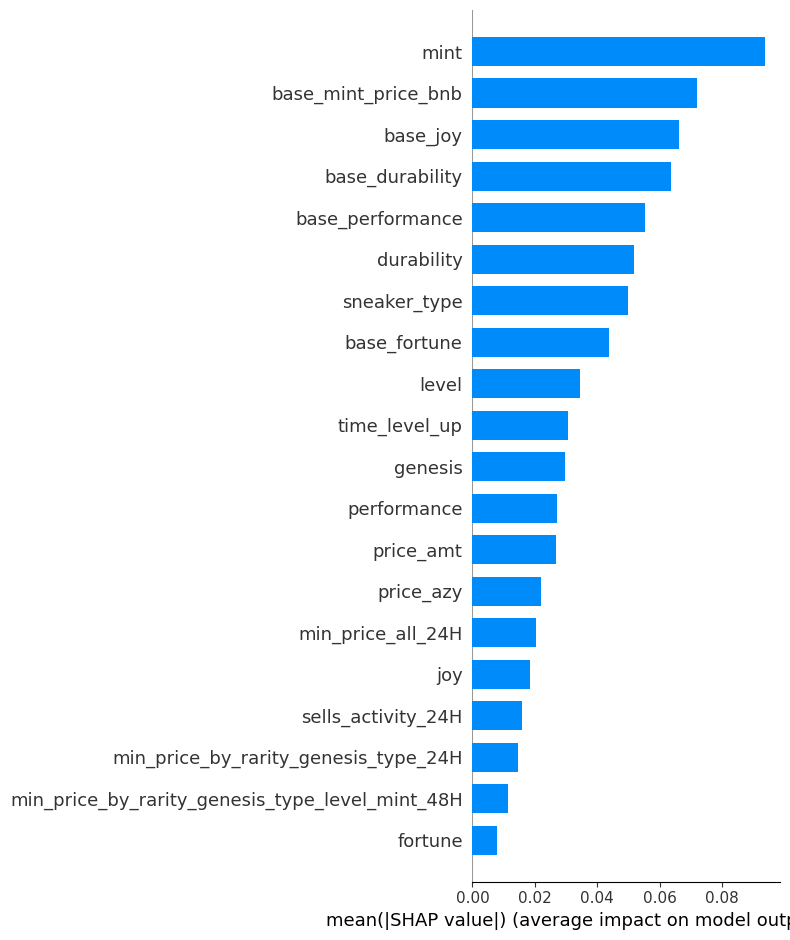

In [194]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [195]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.057369
0:	learn: 1.0366353	total: 3.09ms	remaining: 3.08s
1:	learn: 0.9948396	total: 6.55ms	remaining: 3.27s
2:	learn: 0.9519904	total: 9.69ms	remaining: 3.22s
3:	learn: 0.9126327	total: 12.3ms	remaining: 3.07s
4:	learn: 0.8783938	total: 14.6ms	remaining: 2.91s
5:	learn: 0.8460537	total: 17.1ms	remaining: 2.83s
6:	learn: 0.8145253	total: 19.5ms	remaining: 2.76s
7:	learn: 0.7859895	total: 21.8ms	remaining: 2.7s
8:	learn: 0.7587618	total: 24.2ms	remaining: 2.66s
9:	learn: 0.7313098	total: 26.5ms	remaining: 2.63s
10:	learn: 0.7062600	total: 28.8ms	remaining: 2.59s
11:	learn: 0.6817319	total: 31.1ms	remaining: 2.56s
12:	learn: 0.6603468	total: 33.5ms	remaining: 2.54s
13:	learn: 0.6385716	total: 35.9ms	remaining: 2.53s
14:	learn: 0.6174876	total: 38.2ms	remaining: 2.51s
15:	learn: 0.5988734	total: 40.7ms	remaining: 2.5s
16:	learn: 0.5804404	total: 43ms	remaining: 2.49s
17:	learn: 0.5629022	total: 45.5ms	remaining: 2.48s
18:	learn: 0.5444203	total: 48.1ms	remaining: 2.

In [196]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.926, 'MAE': 0.091, 'MSE': 0.029, 'RMSE': 0.17, 'MAPE': 0.106}

In [197]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.926, 'MAE': 0.091, 'MSE': 0.029, 'RMSE': 0.17, 'MAPE': 0.106}

In [198]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.926, 'MAE': 0.091, 'MSE': 0.029, 'RMSE': 0.17, 'MAPE': 0.106}

## Fit full Model

In [199]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.058799
0:	learn: 0.9869014	total: 3.06ms	remaining: 3.06s
1:	learn: 0.9443458	total: 6.48ms	remaining: 3.23s
2:	learn: 0.9040910	total: 9.53ms	remaining: 3.17s
3:	learn: 0.8677755	total: 12.4ms	remaining: 3.1s
4:	learn: 0.8326822	total: 14.9ms	remaining: 2.97s
5:	learn: 0.7997403	total: 17.5ms	remaining: 2.9s
6:	learn: 0.7694735	total: 20ms	remaining: 2.83s
7:	learn: 0.7402165	total: 22.3ms	remaining: 2.76s
8:	learn: 0.7111312	total: 24.8ms	remaining: 2.73s
9:	learn: 0.6853097	total: 27.4ms	remaining: 2.71s
10:	learn: 0.6608843	total: 29.9ms	remaining: 2.68s
11:	learn: 0.6391528	total: 32.4ms	remaining: 2.67s
12:	learn: 0.6174843	total: 35.1ms	remaining: 2.66s
13:	learn: 0.5978295	total: 37.6ms	remaining: 2.65s
14:	learn: 0.5798275	total: 40.1ms	remaining: 2.63s
15:	learn: 0.5614175	total: 42.6ms	remaining: 2.62s
16:	learn: 0.5419607	total: 45.1ms	remaining: 2.61s
17:	learn: 0.5265950	total: 47.7ms	remaining: 2.6s
18:	learn: 0.5106482	total: 50ms	remaining: 2.58s

### Test

In [200]:
i=1800

In [201]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                                 common
sneaker_type                                         sprinter
genesis                                                 False
level                                                     0.0
base_performance                                          8.9
base_fortune                                              8.0
base_joy                                                  7.4
base_durability                                           3.8
performance                                               8.9
fortune                                                   8.0
joy                                                       7.4
durability                                                3.8
mint                                                      0.0
buy_count_24H                                             319
min_price_all_24H                                         0.7
sells_activity_24H                                   1.830721
min_pric

In [202]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [203]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.847

In [204]:
data.iloc[i]['price']

0.83

iteritems is deprecated and will be removed in a future version. Use .items instead.


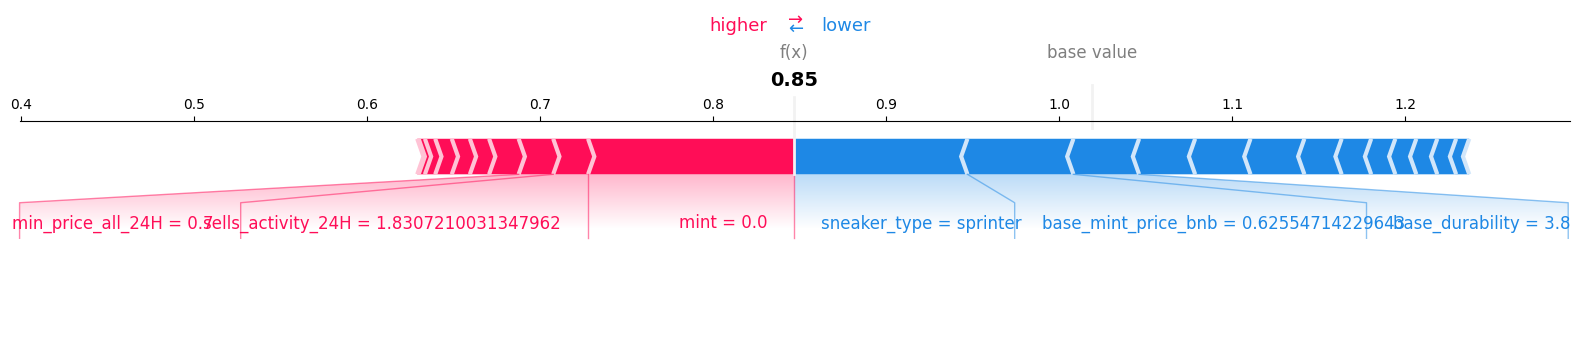

In [205]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [206]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [207]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [208]:
X.genesis.value_counts()

False    7224
True     2659
Name: genesis, dtype: int64

In [209]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,ranger,False,5.0,8.0,7.4,5.0,2.5,27.0,10.9,7.5,4.0,0.0
1,common,ranger,False,5.0,7.8,9.9,6.2,2.5,26.8,14.9,9.2,4.0,0.0
2,common,ranger,False,5.0,8.0,4.0,2.9,4.9,27.0,6.0,4.4,7.4,2.0
3,common,ranger,False,5.0,8.3,7.6,1.0,9.6,18.3,20.6,1.5,14.6,2.0
4,common,hiker,True,10.0,6.3,8.6,9.0,5.1,34.3,17.3,18.0,18.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9878,common,hiker,False,5.0,9.2,4.8,10.0,7.6,28.7,7.3,15.0,11.6,2.0
9879,common,sprinter,False,5.0,8.5,1.5,5.1,3.9,24.0,2.4,7.6,9.9,2.0
9880,common,hiker,False,5.0,8.0,4.0,6.1,9.9,24.0,6.0,9.1,17.9,2.0
9881,common,hiker,False,6.0,2.3,6.0,8.4,6.1,21.5,9.6,13.2,9.7,2.0


In [210]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.12s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.11s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:06,  2.14s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:08,  2.13s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:10,  2.12s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:12,  2.13s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:14,  2.12s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:16,  2.11s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:19,  2.10s/it]iteritems is deprec

In [211]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.825,0.0772
MAE,0.165,0.0122
MSE,0.207,0.1554
RMSE,0.440,0.1145
MAPE,0.142,0.0061


In [212]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.825,0.0772
MAE,0.165,0.0122
MSE,0.207,0.1554
RMSE,0.440,0.1145
MAPE,0.142,0.0061


In [213]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.823, 'MAE': 0.165, 'MSE': 0.207, 'RMSE': 0.455, 'MAPE': 0.142}

In [214]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


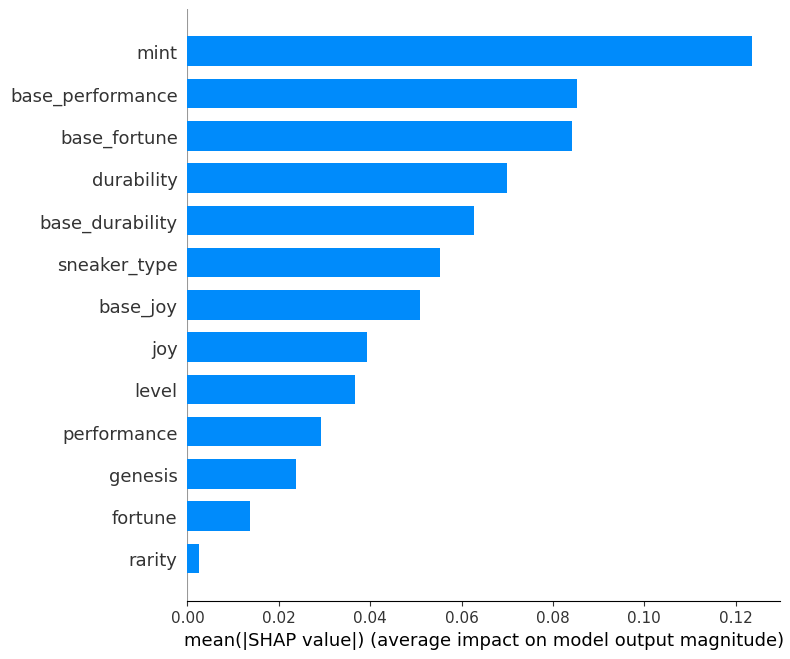

In [215]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [216]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [217]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.057369
0:	learn: 1.0366093	total: 2.85ms	remaining: 2.85s
1:	learn: 0.9963507	total: 5.76ms	remaining: 2.87s
2:	learn: 0.9566740	total: 8.5ms	remaining: 2.82s
3:	learn: 0.9207543	total: 10.8ms	remaining: 2.69s
4:	learn: 0.8866318	total: 13ms	remaining: 2.59s
5:	learn: 0.8540285	total: 15.2ms	remaining: 2.52s
6:	learn: 0.8247259	total: 17.4ms	remaining: 2.46s
7:	learn: 0.7960052	total: 19.4ms	remaining: 2.4s
8:	learn: 0.7691058	total: 21.3ms	remaining: 2.34s
9:	learn: 0.7442255	total: 23.4ms	remaining: 2.32s
10:	learn: 0.7209885	total: 25.6ms	remaining: 2.31s
11:	learn: 0.6968608	total: 27.9ms	remaining: 2.29s
12:	learn: 0.6760790	total: 30.4ms	remaining: 2.31s
13:	learn: 0.6577951	total: 32.6ms	remaining: 2.3s
14:	learn: 0.6394648	total: 34.7ms	remaining: 2.28s
15:	learn: 0.6245389	total: 37ms	remaining: 2.28s
16:	learn: 0.6076404	total: 39.3ms	remaining: 2.27s
17:	learn: 0.5932966	total: 41.5ms	remaining: 2.26s
18:	learn: 0.5780844	total: 43.5ms	remaining: 2.25s

{'R2': 0.27, 'MAE': 0.296, 'MSE': 0.284, 'RMSE': 0.533, 'MAPE': 0.345}

## Fit full Base model

In [218]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.058799
0:	learn: 0.9900819	total: 3.55ms	remaining: 3.54s
1:	learn: 0.9517870	total: 6.82ms	remaining: 3.4s
2:	learn: 0.9150129	total: 9.62ms	remaining: 3.2s
3:	learn: 0.8798638	total: 12ms	remaining: 2.99s
4:	learn: 0.8471297	total: 14.4ms	remaining: 2.86s
5:	learn: 0.8150003	total: 16.8ms	remaining: 2.77s
6:	learn: 0.7859093	total: 18.8ms	remaining: 2.67s
7:	learn: 0.7595452	total: 21ms	remaining: 2.61s
8:	learn: 0.7345338	total: 23.4ms	remaining: 2.58s
9:	learn: 0.7110034	total: 25.7ms	remaining: 2.54s
10:	learn: 0.6893962	total: 28ms	remaining: 2.52s
11:	learn: 0.6680587	total: 30.3ms	remaining: 2.5s
12:	learn: 0.6494758	total: 32.7ms	remaining: 2.48s
13:	learn: 0.6320652	total: 35.1ms	remaining: 2.47s
14:	learn: 0.6158971	total: 37.3ms	remaining: 2.45s
15:	learn: 0.6006702	total: 39.7ms	remaining: 2.44s
16:	learn: 0.5866588	total: 42ms	remaining: 2.43s
17:	learn: 0.5736770	total: 44.6ms	remaining: 2.43s
18:	learn: 0.5605844	total: 46.8ms	remaining: 2.42s
19:

### Test

In [219]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [220]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

1.722

iteritems is deprecated and will be removed in a future version. Use .items instead.


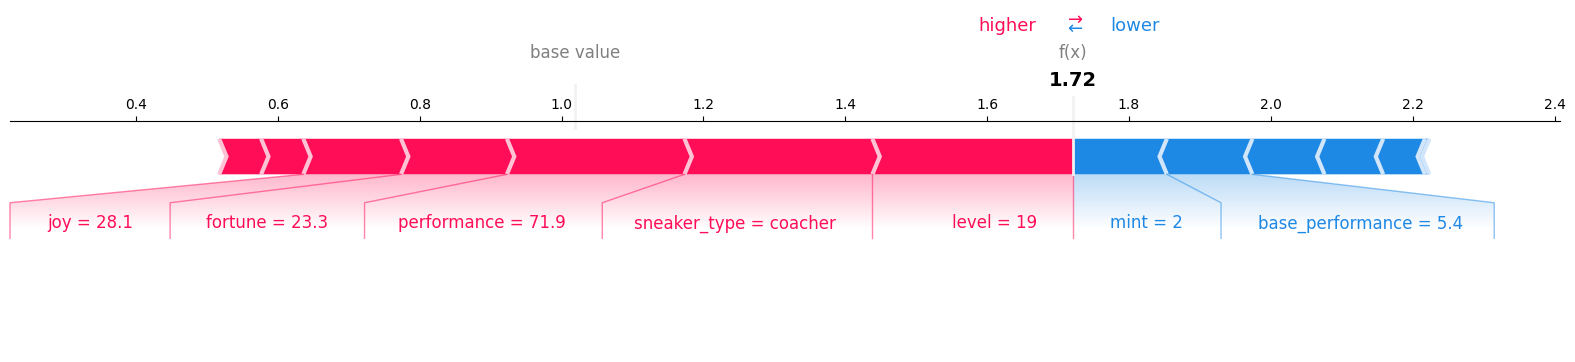

In [221]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

iteritems is deprecated and will be removed in a future version. Use .items instead.


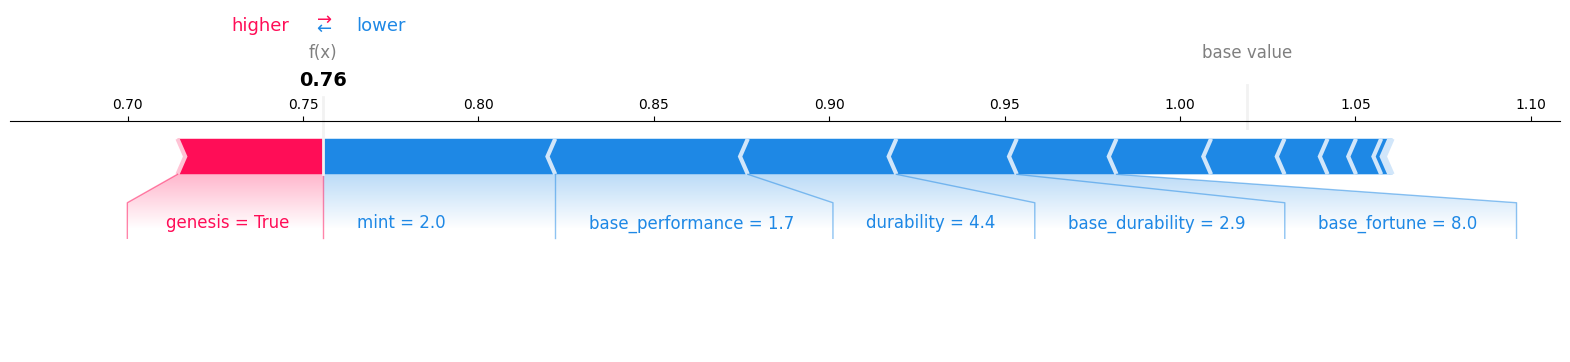

In [222]:
sample = data[data['token_id'] == 20928][model.feature_names_][:1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
#plt.savefig(f'explainer_{VERSION}.png', dpi=700)
#plt.show()

In [223]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [224]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


In [225]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [226]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1664815817,49091,65431,buy,0xdbb9d0c276e0556bcb6104251c869e44161c9648,0x76ddf6f413b2cb6a8e217df19db4e6f19de61be0,0.80,box,common,NaN,...,390.0,9213.0,763.0,0.0,411.0,2380.0,5989.0,12193.0,103.0,1.641026
1,1664815634,49078,65423,buy,0x6022b378180c7c8edbefd19d21dce026b9fd008d,0xdf1f11a3e357c9b6469655ae76074a424e852bf0,0.83,box,common,NaN,...,392.0,9213.0,765.0,0.0,414.0,2383.0,5992.0,12194.0,104.0,1.666667
2,1664815157,49150,58188,buy,0x6df8defc8a6ddf46c805681f27cf5b3aaad9e950,0xdf1f11a3e357c9b6469655ae76074a424e852bf0,0.81,box,common,NaN,...,391.0,9209.0,767.0,0.0,422.0,2385.0,5994.0,12191.0,104.0,1.666667
3,1664813802,49085,65085,buy,0x8373712cff16e48ba58268d3f5e6dbb888e1cbd8,0xdf1f11a3e357c9b6469655ae76074a424e852bf0,0.82,box,common,NaN,...,391.0,9208.0,766.0,0.0,441.0,2394.0,5997.0,12183.0,105.0,1.692308
4,1664813229,49095,65211,buy,0xbc0b088ec82d384c4fed8f2794d23482eda93202,0x4dec78c6502fef59bcdeed868a7ef3608f0bb58e,0.81,box,common,NaN,...,388.0,9208.0,766.0,0.0,447.0,2398.0,6000.0,12185.0,105.0,1.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,905,0,397,1702,2056,2549,NaN,NaN
1171,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,904,0,388,1664,2002,2492,NaN,NaN
1172,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,903,0,253,1505,1844,2328,NaN,NaN
1173,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,904,0,249,1502,1840,2324,NaN,NaN


In [227]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [228]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [229]:
len(data)

1175

In [230]:
len(data[data.date >= START_DATE])

809

In [231]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [232]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659602e+09,6978.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.676773
1,1.657800e+09,11145.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.676012
2,1.657800e+09,23229.0,6.0,4.0,NaN,1800.0,300.0,200.0,0.677113
3,1.657802e+09,21564.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.639683
4,1.657801e+09,38277.0,8.0,3.0,NaN,1800.0,300.0,200.0,0.642806
...,...,...,...,...,...,...,...,...,...
804,1.657806e+09,2413.0,11.0,8.0,NaN,1800.0,300.0,200.0,0.448675
805,1.664724e+09,3578.0,0.0,0.0,NaN,1800.0,300.0,200.0,0.447992
806,1.664703e+09,899.0,0.0,0.0,NaN,1800.0,300.0,200.0,0.447826
807,1.662810e+09,6092.0,1.0,3.0,NaN,1800.0,300.0,200.0,0.448854


In [233]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1662164401,21798,40436,buy,False,hiker,hiker,2022-09-03 00:20:01
1,1662170890,21796,40464,buy,False,hiker,sprinter,2022-09-03 02:08:10
2,1662171007,21614,38512,buy,False,coacher,coacher,2022-09-03 02:10:07
3,1662181762,21801,40467,buy,False,ranger,ranger,2022-09-03 05:09:22
4,1662186301,21623,38529,buy,False,coacher,coacher,2022-09-03 06:25:01
...,...,...,...,...,...,...,...,...
804,1664813229,49095,65211,buy,False,ranger,ranger,2022-10-03 16:07:09
805,1664813802,49085,65085,buy,False,ranger,ranger,2022-10-03 16:16:42
806,1664815157,49150,58188,buy,False,ranger,hiker,2022-10-03 16:39:17
807,1664815634,49078,65423,buy,False,ranger,ranger,2022-10-03 16:47:14


In [234]:
data.genesis.value_counts()

False    763
True      46
Name: genesis, dtype: int64

In [235]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [236]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [237]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [238]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1662164401,21798,40436,buy,0xc57ca482a3e1d0eef363166295962163b2f64ed0,0x710b6677ea43dc7cbf513248b896a6f28171b709,1.13,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1662170890,21796,40464,buy,0xf7b7c0f111fe7bf762fc2c706aee194a39758e95,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.13,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
2,1662171007,21614,38512,buy,0x2a3f0c8349bde254599ed019a2d1994de06b7803,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.18,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
3,1662181762,21801,40467,buy,0x80dd92e3473e45c935edce170191810dc93bc56b,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.09,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1662186301,21623,38529,buy,0x50975867d5c0bad1b78ebf4b06252be9bdb76c64,0x741d48c325f4d29e9961cc86239a96070b3a1f4e,1.20,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,1664813229,49095,65211,buy,0xbc0b088ec82d384c4fed8f2794d23482eda93202,0x4dec78c6502fef59bcdeed868a7ef3608f0bb58e,0.81,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
805,1664813802,49085,65085,buy,0x8373712cff16e48ba58268d3f5e6dbb888e1cbd8,0xdf1f11a3e357c9b6469655ae76074a424e852bf0,0.82,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
806,1664815157,49150,58188,buy,0x6df8defc8a6ddf46c805681f27cf5b3aaad9e950,0xdf1f11a3e357c9b6469655ae76074a424e852bf0,0.81,box,common,NaN,...,0,1,0,0,0,0,0,0,0,0
807,1664815634,49078,65423,buy,0x6022b378180c7c8edbefd19d21dce026b9fd008d,0xdf1f11a3e357c9b6469655ae76074a424e852bf0,0.83,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0


In [239]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [240]:
data['ranger_hiker'].sum()

77

## FE

In [241]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [242]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [243]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [244]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.28it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.28it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:02,  1.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:03,  1.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:03,  1.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:04,  1.30it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:05,  1.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:06,  1.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:06,  1.29it/s]iteritems is deprec

In [245]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.790,0.2601
MAE,0.087,0.0720
MSE,0.349,0.8665
RMSE,0.332,0.4964
MAPE,0.050,0.0091


In [246]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.790,0.2601
MAE,0.087,0.0720
MSE,0.349,0.8665
RMSE,0.332,0.4964
MAPE,0.050,0.0091


In [247]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.437, 'MAE': 0.087, 'MSE': 0.348, 'RMSE': 0.59, 'MAPE': 0.05}

iteritems is deprecated and will be removed in a future version. Use .items instead.


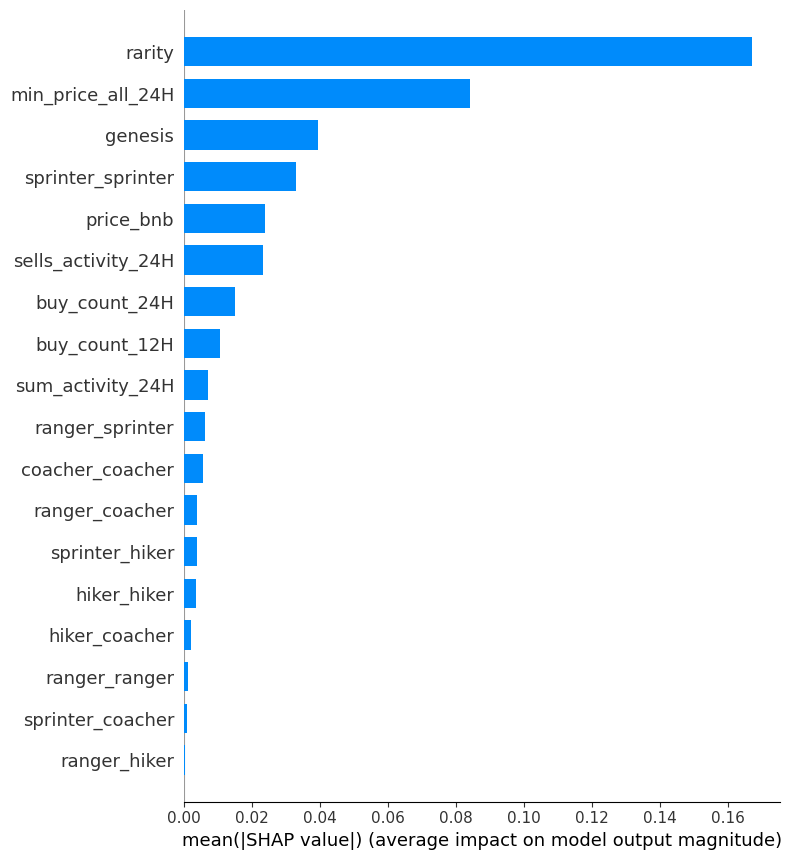

In [248]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [249]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.039595
0:	learn: 0.7728459	total: 1.61ms	remaining: 1.61s
1:	learn: 0.7588615	total: 2.79ms	remaining: 1.39s
2:	learn: 0.7453422	total: 4.21ms	remaining: 1.4s
3:	learn: 0.7331356	total: 5.26ms	remaining: 1.31s
4:	learn: 0.7203532	total: 6.31ms	remaining: 1.25s
5:	learn: 0.7084220	total: 7.3ms	remaining: 1.21s
6:	learn: 0.6956036	total: 8.22ms	remaining: 1.17s
7:	learn: 0.6833786	total: 9.06ms	remaining: 1.12s
8:	learn: 0.6725935	total: 9.79ms	remaining: 1.08s
9:	learn: 0.6600482	total: 10.4ms	remaining: 1.03s
10:	learn: 0.6485519	total: 11.1ms	remaining: 994ms
11:	learn: 0.6364485	total: 11.8ms	remaining: 970ms
12:	learn: 0.6256632	total: 12.5ms	remaining: 951ms
13:	learn: 0.6141307	total: 13.2ms	remaining: 929ms
14:	learn: 0.6037768	total: 13.9ms	remaining: 914ms
15:	learn: 0.5937950	total: 14.4ms	remaining: 889ms
16:	learn: 0.5844627	total: 15.1ms	remaining: 876ms
17:	learn: 0.5747274	total: 15.8ms	remaining: 863ms
18:	learn: 0.5649456	total: 16.2ms	remaining: 

### Test

In [250]:
i = 250

In [251]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1662994885,
 'mrk_id': 27361,
 'token_id': 47029,
 'event': 'buy',
 'wallet_from': '0x0885157dbb0db47f63477b1d88c62a8b5193aefa',
 'wallet_to': '0xf06301c9b159e20d019995b4943f075b6b28e246',
 'price': 1.0,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0.0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 19505.0,
 'parent2': 19511.0,
 'genesis': False,
 'parent1_sneaker_type': 'ranger',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 297.38936778,
 'price_azy': 0.09238833,
 'price_amt': 0.55592094,
 'wallet_from_buy_count': 2.0,
 'wallet_from_all_count': 9.0,
 'token_all_activity_3H': 0.0,
 'token_sell_activity_6H': 0.0,
 'buy_count_12H': 16.0,
 'buy_count_24H': 25,
 'buy_count_48H': 55.0,
 'sell_count_12H': 18.0,
 'sell_count_24H': 40,
 'sell_count_48H': 96.0,
 'cancel_count_12H': 9.0,
 'cancel_count_24H':

In [252]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H              16.0
buy_count_24H                25
sum_activity_24H             89
sells_activity_24H          1.6
min_price_all_24H           0.9
price_bnb                   NaN
ranger_sprinter               1
ranger_hiker                NaN
ranger_coacher              NaN
sprinter_hiker              NaN
sprinter_coacher            NaN
hiker_coacher               NaN
ranger_ranger               NaN
sprinter_sprinter           NaN
hiker_hiker                 NaN
coacher_coacher             NaN
wallet_from_buy_count       2.0
wallet_from_all_count       9.0
dtype: object

In [253]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.053

In [254]:
data.iloc[i]['price']

1.0

In [255]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.488

In [256]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

2.907

# Box Base Model

In [257]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [258]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [259]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [260]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             809 non-null    object
 1   genesis            809 non-null    bool  
 2   ranger_sprinter    809 non-null    int64 
 3   ranger_hiker       809 non-null    int64 
 4   ranger_coacher     809 non-null    int64 
 5   sprinter_hiker     809 non-null    int64 
 6   sprinter_coacher   809 non-null    int64 
 7   hiker_coacher      809 non-null    int64 
 8   ranger_ranger      809 non-null    int64 
 9   sprinter_sprinter  809 non-null    int64 
 10  hiker_hiker        809 non-null    int64 
 11  coacher_coacher    809 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 70.4+ KB


In [261]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.03it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.97it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  1.95it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:02,  1.96it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  1.96it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:03,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:03,  1.99it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:04,  1.98it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:04,  1.97it/s]iteritems is deprec

In [262]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.693,0.2485
MAE,0.156,0.0703
MSE,0.358,0.8667
RMSE,0.379,0.4714
MAPE,0.130,0.0171


In [263]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.693,0.2485
MAE,0.156,0.0703
MSE,0.358,0.8667
RMSE,0.379,0.4714
MAPE,0.130,0.0171


In [264]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.421, 'MAE': 0.156, 'MSE': 0.358, 'RMSE': 0.598, 'MAPE': 0.13}

iteritems is deprecated and will be removed in a future version. Use .items instead.


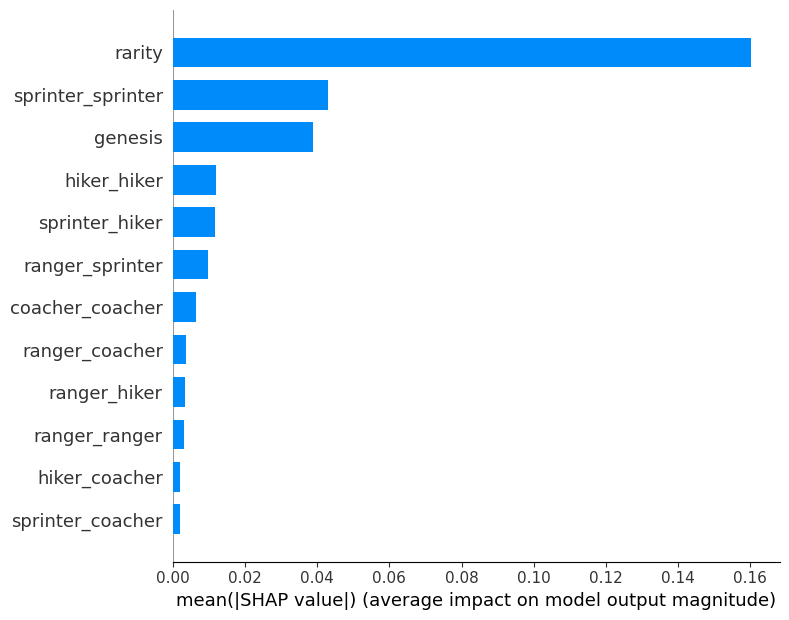

In [265]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [266]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.039595
0:	learn: 0.7712614	total: 1.29ms	remaining: 1.29s
1:	learn: 0.7595360	total: 1.98ms	remaining: 986ms
2:	learn: 0.7462217	total: 2.59ms	remaining: 861ms
3:	learn: 0.7340772	total: 3.41ms	remaining: 849ms
4:	learn: 0.7220915	total: 3.83ms	remaining: 762ms
5:	learn: 0.7111885	total: 4.52ms	remaining: 749ms
6:	learn: 0.7006898	total: 5.14ms	remaining: 729ms
7:	learn: 0.6912018	total: 5.93ms	remaining: 735ms
8:	learn: 0.6812587	total: 6.65ms	remaining: 732ms
9:	learn: 0.6721805	total: 7ms	remaining: 693ms
10:	learn: 0.6621760	total: 7.41ms	remaining: 667ms
11:	learn: 0.6526692	total: 7.69ms	remaining: 633ms
12:	learn: 0.6437538	total: 8.31ms	remaining: 631ms
13:	learn: 0.6355333	total: 8.86ms	remaining: 624ms
14:	learn: 0.6272311	total: 9.47ms	remaining: 622ms
15:	learn: 0.6192652	total: 9.95ms	remaining: 612ms
16:	learn: 0.6133024	total: 10.5ms	remaining: 606ms
17:	learn: 0.6041369	total: 10.9ms	remaining: 595ms
18:	learn: 0.5970653	total: 11.5ms	remaining: 5

## Test

In [267]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.439

In [268]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [269]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [270]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [271]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

0.994

In [272]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.091

In [273]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.091

In [274]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.41

In [275]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.051

In [276]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.004

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [141]:
# import ast
# import json

In [142]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [143]:
# print(json.dumps(json_data))

In [144]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [145]:
#output = json.loads(r.text)

In [146]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

групировку делать по sell оредерам